In [1]:
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from time import time
from feature_generators.prediction_features_generator import *
from feature_generators.helpers import *
import feature_generators.ngram as ngram
import warnings
warnings.filterwarnings("ignore")

GloVe model loaded!


In [6]:
# Load the saved booster model
with open('saved_data/xgb_model_early.pkl', 'rb') as mod:
    xgb_mod = pickle.load(mod)

In [7]:
def process(data):
    """
    Preprocesses the data provided and generates
    unigrams, bigrams and trigrams.
    Saves the features in the separate columns in the dataframe.
    
    Input: Dataframe
    
    Returns Dataframe
    """
    
    # print (data.iloc[1])
    print ('>>> Data shape: ', data.shape)
    
    t0 = time()
    print("---Generating n-grams Features!---")
    print ("Generating unigram")
    data["Headline_unigram"] = data["Headline"].map(lambda x: preprocess_data(x))
    data["articleBody_unigram"] = data["articleBody"].map(lambda x: preprocess_data(x))
    
    print ("Generating bigram")
    join_str = "_"
    data["Headline_bigram"] = data["Headline_unigram"].map(lambda x: ngram.getBigram(x, join_str))
    data["articleBody_bigram"] = data["articleBody_unigram"].map(lambda x: ngram.getBigram(x, join_str))

    print ("Generating trigram")
    join_str = "_"
    data["Headline_trigram"] = data["Headline_unigram"].map(lambda x: ngram.getTrigram(x, join_str))
    data["articleBody_trigram"] = data["articleBody_unigram"].map(lambda x: ngram.getTrigram(x, join_str))

    print("---n-gram Features generated---")
    print("Time taken: {} seconds\n".format(time() - t0))
    
    return data


In [8]:
def build_test_data(data):
    """
    Generates various features needed to predict
    the class of the news.
    
    Input: DataFrame
    Returns Array of generated features.
    """

    data = process(data)
    
    generators = [
                  CountFeatureGenerator,
                  TfidfFeatureGenerator,
                  Word2VecFeatureGenerator,
                  SentimentFeatureGenerator,
                  ReadabilityFeatureGenerator
                  # Add more generators
                 ]
    
    # Class generators one by one to generate features
    features = [feature for generator in generators for feature in generator(data)]
    print("Total number of raw features: {}".format(len(features)))
    
    # Stack and return the features
    return np.hstack(features)

In [9]:
def check(news):
    """
    Predicts the probable class and corresponding probabilites
    of the news belonging to a certian clas
    
    Input: DataFrame of news: Headline and Article body only
    Returns DataFrame with class predictions
    """

    test_x = build_test_data(news)
    
    # Save feature_vector for quick debugging
    with open('tmp/feature_vector', 'wb') as fv:
        pickle.dump(test_x, fv)
        

    dtest = xgb.DMatrix(test_x)
    print("Total Feature count in the test set: ", len(dtest.feature_names))
    
    # Use Booster to predict class
    pred_prob_y = xgb_mod.predict(dtest).reshape(test_x.shape[0], 2) # predicted probabilities
    pred_y = np.argmax(pred_prob_y, axis=1)

    LABELS = ['reliable', 'unreliable']
    predicted = [LABELS[int(a)] for a in pred_y]

    # print (predicted)
    print ('pred_y.shape: ', pred_y.shape)
    predicted = [LABELS[int(a)] for a in pred_y]

    news['preds'] = predicted
    news['Reliable'] = pred_prob_y[:, 0]
    news['Unreliable'] = pred_prob_y[:, 1]
    
    return news

In [12]:
data = pd.read_csv("datasets/kaggle_processed.csv", encoding='utf-8')
# data.drop(columns=['type', 'length'], inplace=True)
# data.columns = ['Headline', 'articleBody', 'target']
data.Headline = data.Headline.astype(str)
data.articleBody = data.articleBody.astype(str)
data.head()

,Headline,articleBody,target,type
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,unreliable
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,reliable
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,unreliable
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,unreliable
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,unreliable


In [7]:
targets_ = {'reliable': '0', 'unreliable': '1'}
data['targets'] = list(map(lambda x: targets_[str(x)], data['type']))
data.head()

,id,type,articleBody,Headline,targets
0,0,reliable,The Onion's violent satire painting fictional ...,"The Onion's Spoof Tweets Spark Anger, Fear; No...",0
1,1,unreliable,"By Tyler Durden / ZeroHedge Back in May, we fi...",“Here’s Why Current Situation is Even Worse Th...,1
2,2,unreliable,"In New York City, yesterday’s morning commute ...",What Is the World Coming to?,1
3,3,unreliable,zerohedge.com / by Steve Saretsky via VanCityC...,Canadian Homeowners Take Out HELOCs To Fund Su...,1
4,4,unreliable,"In August number, Europe’s major powers threw ...",The Christmas Truce of World War I,1


In [13]:
df_output = check(data[:100])

>>> Data shape:  (100, 4)
---Generating n-grams Features!---
Generating unigram
Generating bigram
Generating trigram
---n-gram Features generated---
Time taken: 1.6727724075317383 seconds


---Generating Counting Features:---
xBasicCounts.shape:  (100, 41)
---Counting Features is complete---
Time taken 4.4804158210754395 seconds


---Generating TFIDF Features:---
xHeadlineTfidf.shape: (100, 1787026)
xBodyTfidf.shape:  (100, 1787026)
simTfidf.shape:  (100, 1)
---TFIDF Features is complete---
Time taken 37.32722544670105 seconds


---Generating Word2Vector Features:---
headlineVec.shape:  (100, 50)
bodyVec.shape:  (100, 50)
simVec.shape:  (100, 1)
---Word2Vector Features is complete---
Time taken 8.87723159790039 seconds


---Generating Sentiment Features:---
headlineSenti.shape:  (100, 4)
bodySenti.shape:  (100, 4)
---Sentiment Features is complete---
Time taken 2.9797685146331787 seconds


---Generating Readability Features:---
xReadable.shape:  (100, 12)
---Readability Features is com

In [23]:
df_output.head()

,Headline,articleBody,target,type,Headline_unigram,articleBody_unigram,Headline_bigram,articleBody_bigram,Headline_trigram,articleBody_trigram,...,difficult_words,linsear_write_formula,gunning_fog,i_me_myself,punct,lexical_diversity,preds,Reliable,Unreliable,predicted
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,unreliable,"[hous, dem, aid, even, see, comey, letter, jas...","[hous, dem, aid, even, see, comey, letter, jas...","[hous_dem, dem_aid, aid_even, even_see, see_co...","[hous_dem, dem_aid, aid_even, even_see, see_co...","[hous_dem_aid, dem_aid_even, aid_even_see, eve...","[hous_dem_aid, dem_aid_even, aid_even_see, eve...",...,144,20.000000,19.94,2,66,66.621622,unreliable,0.014872,0.985128,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,reliable,"[flynn, hillari, clinton, big, woman, campus, ...","[ever, get, feel, life, circl, roundabout, rat...","[flynn_hillari, hillari_clinton, clinton_big, ...","[ever_get, get_feel, feel_life, life_circl, ci...","[flynn_hillari_clinton, hillari_clinton_big, c...","[ever_get_feel, get_feel_life, feel_life_circl...",...,130,15.250000,23.52,7,66,63.030303,reliable,0.974391,0.025609,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,unreliable,"[whi, truth, might, get, fire]","[whi, truth, might, get, fire, octob, 29, 2016...","[whi_truth, truth_might, might_get, get_fire]","[whi_truth, truth_might, might_get, get_fire, ...","[whi_truth_might, truth_might_get, might_get_f...","[whi_truth_might, truth_might_get, might_get_f...",...,227,10.833333,24.99,1,130,111.478261,unreliable,0.100930,0.899070,1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,unreliable,"[15, civilian, kill, singl, us, airstrik, iden...","[video, 15, civilian, kill, singl, us, airstri...","[15_civilian, civilian_kill, kill_singl, singl...","[video_15, 15_civilian, civilian_kill, kill_si...","[15_civilian_kill, civilian_kill_singl, kill_s...","[video_15_civilian, 15_civilian_kill, civilian...",...,85,18.666667,25.22,1,36,51.380952,unreliable,0.002439,0.997561,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,unreliable,"[iranian, woman, jail, fiction, unpublish, sto...","[print, iranian, woman, sentenc, six, year, pr...","[iranian_woman, woman_jail, jail_fiction, fict...","[print_iranian, iranian_woman, woman_sentenc, ...","[iranian_woman_jail, woman_jail_fiction, jail_...","[print_iranian_woman, iranian_woman_sentenc, w...",...,32,30.000000,71.57,0,15,19.957447,unreliable,0.032515,0.967485,1


In [26]:
y_targets = df_output['target']
y_predicted = df_output['predicted'].astype(int)

In [21]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
%matplotlib inline

In [27]:
print(classification_report(y_targets, y_predicted))

             precision    recall  f1-score   support

          0       0.82      0.58      0.68        55
          1       0.62      0.84      0.72        45

avg / total       0.73      0.70      0.70       100



In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[32 23]
 [ 7 38]]


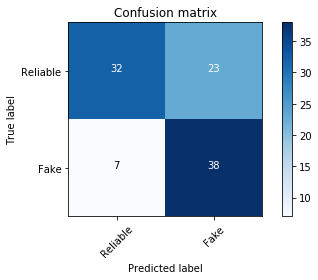

In [30]:
plot_confusion_matrix(confusion_matrix(y_targets, y_predicted),['Reliable', 'Fake'])

In [19]:
targets_ = {'reliable': '0', 'unreliable': '1'}
df_output['predicted'] = list(map(lambda x: targets_[str(x)], df_output['preds']))

In [12]:
df_needed = df_output[['target', 'preds']]

In [13]:
df_needed.to_csv('datasets/kaggle_clean_preds.csv', index=False)

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Visualize the importance of each feature in the model.
fig, ax = plt.subplots(1, 1, figsize=(20,30))
important_feats = xgb.plot_importance(xgb_mod, ax=ax, height=0.2)

In [ ]:
important_feats.figure.savefig('results/important_features.png', format='png', dpi=300)

In [42]:
# Make deciscion tree
fig = xgb.to_graphviz(xgb_mod)

In [43]:
fig.render('results/decision_tree.png', format='png')

'graph_.png'

## For quick debugging.

In [18]:
import pickle
import xgboost as xgb

with open('saved_data/xgb_model.pkl', 'rb') as mod:
    xgb_mod = pickle.load(mod)

with open('tmp/feature_vector', 'rb') as fv:
    test_x = pickle.load(fv)

dtest = xgb.DMatrix(test_x)

print("Total Feature count in the test set: ", len(dtest.feature_names))

dtest = xgb.DMatrix(test_x)
print("Total Feature count in the test set: ", len(dtest.feature_names))

# Use Booster to predict class
pred_prob_y = xgb_mod.predict(dtest).reshape(test_x.shape[0], 4) # predicted probabilities
pred_y = np.argmax(pred_prob_y, axis=1)

LABELS = ['reliable', 'unreliable']
predicted = [LABELS[int(a)] for a in pred_y]

# print (predicted)
print ('pred_y.shape: ', pred_y.shape)
predicted = [LABELS[int(a)] for a in pred_y]

news['preds'] = predicted
news['Reliable'] = pred_prob_y[:, 0]
news['Unreliable'] = pred_prob_y[:, 1]


Total Feature count in the test set:  163
Total Feature count in the test set:  163
pred_y.shape:  (100,)
